# Imports and Defaults

In [1]:
import os

import seaborn as sns
import numpy as np
import polars as pl

In [4]:
sns.set_theme(style="darkgrid")
experiment = "stochastic_volatility"
num_params = 503
data_dir = os.path.join("..", "..", "data", experiment)

# Load Dataframe

In [5]:
path = os.path.join(data_dir, "summary.parquet")
summary = pl.read_parquet(path)
summary.head()

chain,damping,max_proposals,metric,probabilistic,reduction_factor,sampler_type,step_count_method,step_size,step_size_factor,hparams,num_nans,max_se1,max_se2,max_rse1,max_rse2,p0_se1,p1_se1,p2_se1,p3_se1,p4_se1,p5_se1,p6_se1,p7_se1,p8_se1,p9_se1,p10_se1,p11_se1,p12_se1,p13_se1,p14_se1,p15_se1,p16_se1,p17_se1,p18_se1,p19_se1,p20_se1,…,p468_rse2,p469_rse2,p470_rse2,p471_rse2,p472_rse2,p473_rse2,p474_rse2,p475_rse2,p476_rse2,p477_rse2,p478_rse2,p479_rse2,p480_rse2,p481_rse2,p482_rse2,p483_rse2,p484_rse2,p485_rse2,p486_rse2,p487_rse2,p488_rse2,p489_rse2,p490_rse2,p491_rse2,p492_rse2,p493_rse2,p494_rse2,p495_rse2,p496_rse2,p497_rse2,p498_rse2,p499_rse2,p500_rse2,p501_rse2,p502_rse2,step_count,step_count_factor
i64,f64,i64,i64,bool,i64,str,str,null,f64,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,null,f64
3,0.05,2,1,false,2,"""drghmc""","""const_traj_len…",null,2.0,"""damping=0.05__…",0,4.821949,24.540029,340.502308,67626.58778,0.046043,0.522244,2.173079,4.821949,1.479935,1.272414,1.068369,1.100333,1.263181,1.124893,1.234429,1.100659,1.097576,1.273436,1.284451,1.223239,1.255232,1.252611,1.241244,1.312192,1.159731,…,0.431349,0.655322,0.360972,0.657828,0.000982,0.00055,1.004682,0.141234,0.23453,0.001194,0.179872,0.932998,0.396001,0.548902,0.348794,0.105667,0.642961,0.008852,0.055032,1.36025,1.092759,0.032793,0.385331,0.013894,0.728155,0.561152,0.001291,0.014241,0.354137,0.386509,0.006911,0.577653,0.026739,0.016789,0.000595,null,null
0,1.0,2,1,false,8,"""drhmc""",null,null,5.0,"""damping=1__max…",141288882,0.684202,2.09604,2.944977,29.588927,0.004466,0.000054,0.002077,0.004609,0.000795,0.000678,0.03668,0.003753,0.000005,0.000376,0.059782,0.015187,0.053576,0.004998,0.03774,0.007829,0.025845,0.056449,0.054868,0.018164,0.01297,…,0.308802,0.00423,0.00003,0.151475,0.07865,0.018445,0.271398,0.000564,1.483473,0.000085,0.011239,0.16892,0.132717,0.112585,0.320091,0.435976,0.060472,0.008831,0.313215,0.313515,0.167812,0.357576,0.295148,0.011754,0.397234,0.000136,0.038206,3.844696,0.003505,0.299978,0.330819,0.252641,0.460662,0.424463,0.078121,null,0.9
3,0.1,4,1,false,2,"""drghmc""","""const_traj_len…",null,2.0,"""damping=0.1__m…",18868877,5.504156,27.398637,388.676404,75504.244541,0.000692,0.619249,1.826564,5.504156,1.791943,1.56964,1.17949,1.179983,1.505442,1.328096,1.49699,1.342662,1.318707,1.563135,1.625142,1.436644,1.618701,1.614739,1.431061,1.530187,1.405298,…,0.359348,0.596122,0.213805,0.642023,0.151658,0.037079,2.141235,0.435735,0.488084,0.005586,0.259749,1.864328,0.816052,0.555246,0.364341,0.055009,0.611913,0.031356,0.147736,1.949158,1.897026,0.133465,1.190701,0.01009,1.298004,0.884988,0.000722,0.006803,0.384317,0.371739,0.177612,1.792193,0.001526,0.170541,0.034758,null,null
1,0.05,4,1,false,2,"""drghmc""","""const_step_cou…",null,1.0,"""damping=0.05__…",1410483,5.418985,26.396324,382.662021,72742.103459,0.002704,0.598678,1.892445,5.418985,1.768106,1.591435,1.172048,1.213532,1.507008,1.318405,1.473545,1.321698,1.303572,1.568678,1.574445,1.407713,1.651824,1.641281,1.449624,1.541647,1.412322,…,0.371335,0.614586,0.21923,0.628423,0.149905,0.042978,2.051262,0.479315,0.568357,0.01161,0.248848,1.76935,0.715247,0.560213,0.393246,0.056229,0.623295,0.037238,0.127445,2.146736,1.725816,0.122714,1.234359,0.01502,1.218775,0.817533,0.000379,0.007995,0.381355,0.378625,0.138404,1.463925,0.00019,0.177583,0.027979,null,null
0,0.1,4,1,false,16,"""drghmc""","""const_step_cou…",null,0.5,"""damping=0.1__m…",0,5.263062,25.92339,371.651541,71438.807274,0.005222,0.589808,1.962002,5.263062,1.688181,1.515193,1.163341,1.172012,1.435729,1.294442,1.432141,1.318885,1.276583,1.477658,1.524799,1.356724,1.57263,1.56333,1.364003,1.474555,1.376956,…,0.36616,0.595426,0.235428,0.642155,0.093878,0.026872,1.702956,0.369359,0.466736,0.004485,0.208784,1.424246,0.542229,0.558637,0.3

# Max Squared Error

/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 0.98, 'Max Squared Error Per Chain')

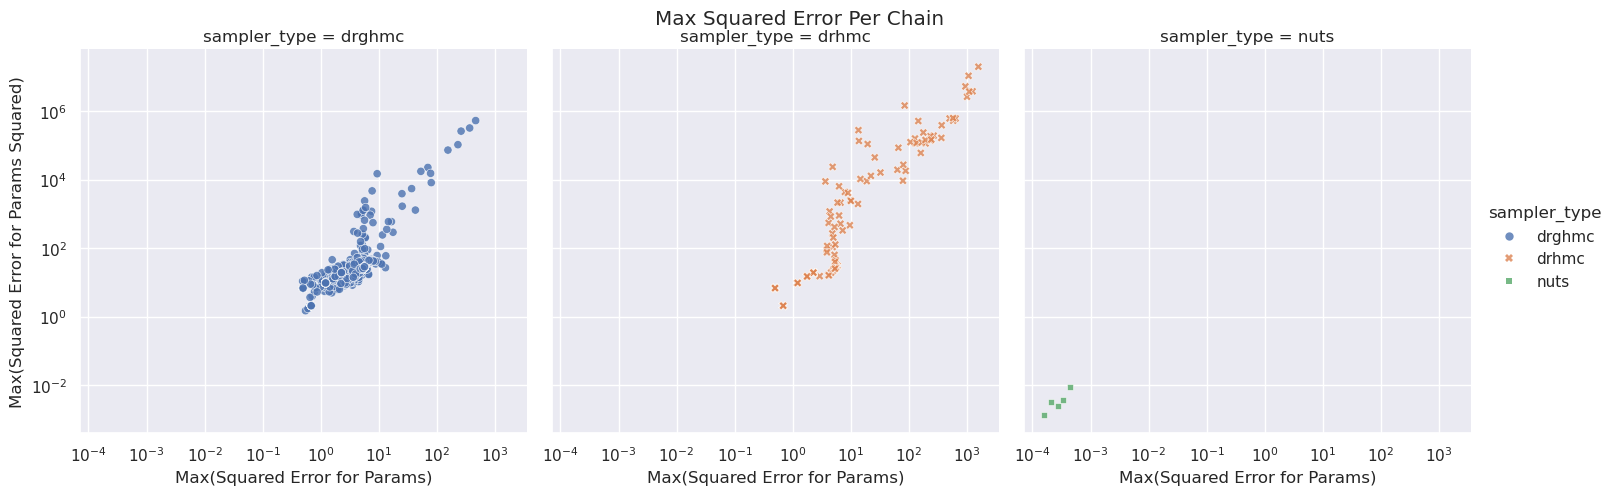

In [7]:
fig = sns.relplot(
    data=summary.to_pandas(),
    kind="scatter",
    x="max_se1",
    y="max_se2",
    hue="sampler_type",
    style="sampler_type",
    alpha=0.8,
    col="sampler_type",
    col_order=["drghmc", "drhmc", "nuts"]
)
# rename x axis and y axis
fig.set(xlabel="Max(Squared Error for Params)", ylabel="Max(Squared Error for Params Squared)")
fig.set(xscale="log", yscale="log")
fig.fig.subplots_adjust(top = 0.9)
fig.fig.suptitle("Max Squared Error Per Chain")

In [8]:
grouped = summary.group_by("hparams").agg([
    pl.col("max_se1").std().alias("se1_std"),
    pl.col("max_se2").std().alias("se2_std"),
    pl.col("max_se1").mean().alias("se1_mean"),
    pl.col("max_se2").mean().alias("se2_mean"),
    pl.col("sampler_type").first().alias("sampler_type"),
    #pl.col("step_count_method").first().alias("step_count_method"),
    pl.col("step_count_factor").first().alias("step_count_factor"),
    pl.col("max_proposals").first().alias("max_proposals"),
    pl.col("reduction_factor").first().alias("reduction_factor"),
    pl.col("damping").first().alias("damping"),
])

# make new Polars column for the max of se1_std and se2_std 
grouped = grouped.with_columns(
    pl.when(pl.col("se1_std") > pl.col("se2_std")).then(pl.col("se1_std")).otherwise(pl.col("se2_std")).alias("max_std")
)
grouped.describe()

statistic,hparams,se1_std,se2_std,se1_mean,se2_mean,sampler_type,step_count_factor,max_proposals,reduction_factor,damping,max_std
str,str,f64,f64,f64,f64,str,f64,f64,f64,f64,f64
"""count""","""881""",881.0,881.0,881.0,881.0,"""881""",80.0,880.0,880.0,880.0,881.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,"""0""",801.0,1.0,1.0,1.0,0.0
"""mean""",null,5.490911,23889.29018,7.946579,12465.307361,null,0.9,3.5,7.5,0.265455,23889.29018
"""std""",null,42.290886,351990.359546,31.185541,173684.957163,null,0.0,1.11867,5.364952,0.290944,351990.359546
"""min""","""damping=0.01__…",0.000113,0.00296,0.000285,0.003978,"""drghmc""",0.9,2.0,2.0,0.01,0.00296
"""25%""",null,0.12413,1.036684,4.492914,22.682951,null,0.9,3.0,4.0,0.05,1.036684
"""50%""",null,0.308066,2.517169,5.330999,26.406605,null,0.9,4.0,8.0,0.1,2.517169
"""75%""",null,0.780062,6.771185,5.526847,27.414248,null,0.9,4.0,8.0,0.5,6.771185
"""max""","""sampler_type=n…",685.726942,8.8057e6,541.215216,3.9806e6,"""nuts""",0.9,5.0,16.0,1.0,8.8057e6


/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 0.98, 'Max Squared Error Per Hyperparameter Setting')

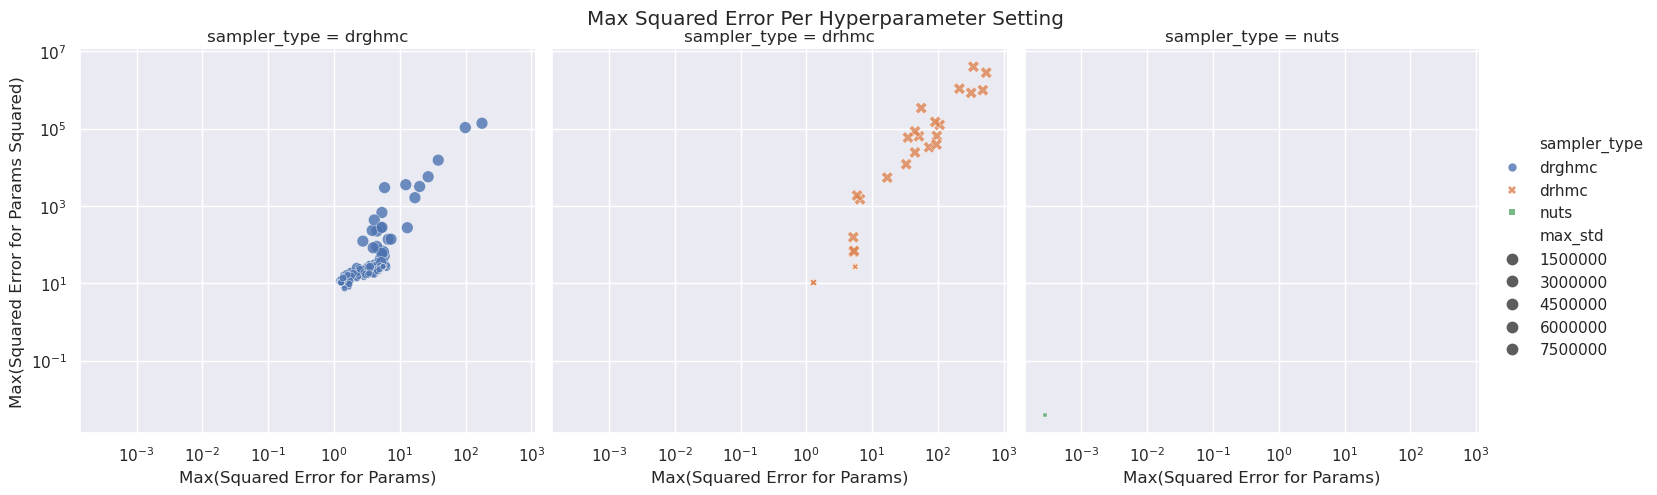

In [11]:
fig = sns.relplot(
    data=grouped.to_pandas(),
    kind="scatter",
    x="se1_mean",
    y="se2_mean",
    hue="sampler_type",
    style="sampler_type",
    alpha=0.8,
    col="sampler_type",
    col_order=["drghmc", "drhmc", "nuts"],
    size="max_std",
    size_norm=(0.5, 50)
)
# rename x axis and y axis
fig.set(xlabel="Max(Squared Error for Params)", ylabel="Max(Squared Error for Params Squared)")
fig.set(xscale="log", yscale="log")
fig.fig.subplots_adjust(top = 0.9)
fig.fig.suptitle("Max Squared Error Per Hyperparameter Setting")

# Per-Parameter Squared Error

In [12]:
value_vars = [f"p{idx}_se1" for idx in range(num_params)] + [f"p{idx}_se2" for idx in range(num_params)]
id_vars = ["hparams", "sampler_type", "chain"]

melted = summary.melt(
    id_vars=id_vars,
    value_vars=value_vars, 
    variable_name="param_error", 
    value_name="squared error"
)

melted = melted.with_columns(
    pl.col("param_error")
    .str.split_exact(by="_", n=1)
    .struct.rename_fields(["param", "error_type"])
).unnest("param_error")

melted = melted.pivot(
    index=id_vars + ["param"],
    columns="error_type",
    values="squared error",
)

melted.head()    

hparams,sampler_type,chain,param,se1,se2
str,str,i64,str,f64,f64
"""damping=0.05__…","""drghmc""",3,"""p0""",0.046043,0.096007
"""damping=1__max…","""drhmc""",0,"""p0""",0.004466,0.480273
"""damping=0.1__m…","""drghmc""",3,"""p0""",0.000692,0.009481
"""damping=0.05__…","""drghmc""",1,"""p0""",0.002704,0.040558
"""damping=0.1__m…","""drghmc""",0,"""p0""",0.005222,0.027291


In [13]:
melted = melted.filter(pl.col("param").str.contains("p[0-4]"))
melted.head()

hparams,sampler_type,chain,param,se1,se2
str,str,i64,str,f64,f64
"""damping=0.05__…","""drghmc""",3,"""p0""",0.046043,0.096007
"""damping=1__max…","""drhmc""",0,"""p0""",0.004466,0.480273
"""damping=0.1__m…","""drghmc""",3,"""p0""",0.000692,0.009481
"""damping=0.05__…","""drghmc""",1,"""p0""",0.002704,0.040558
"""damping=0.1__m…","""drghmc""",0,"""p0""",0.005222,0.027291


/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 0.98, 'Squared Error Per Chain')

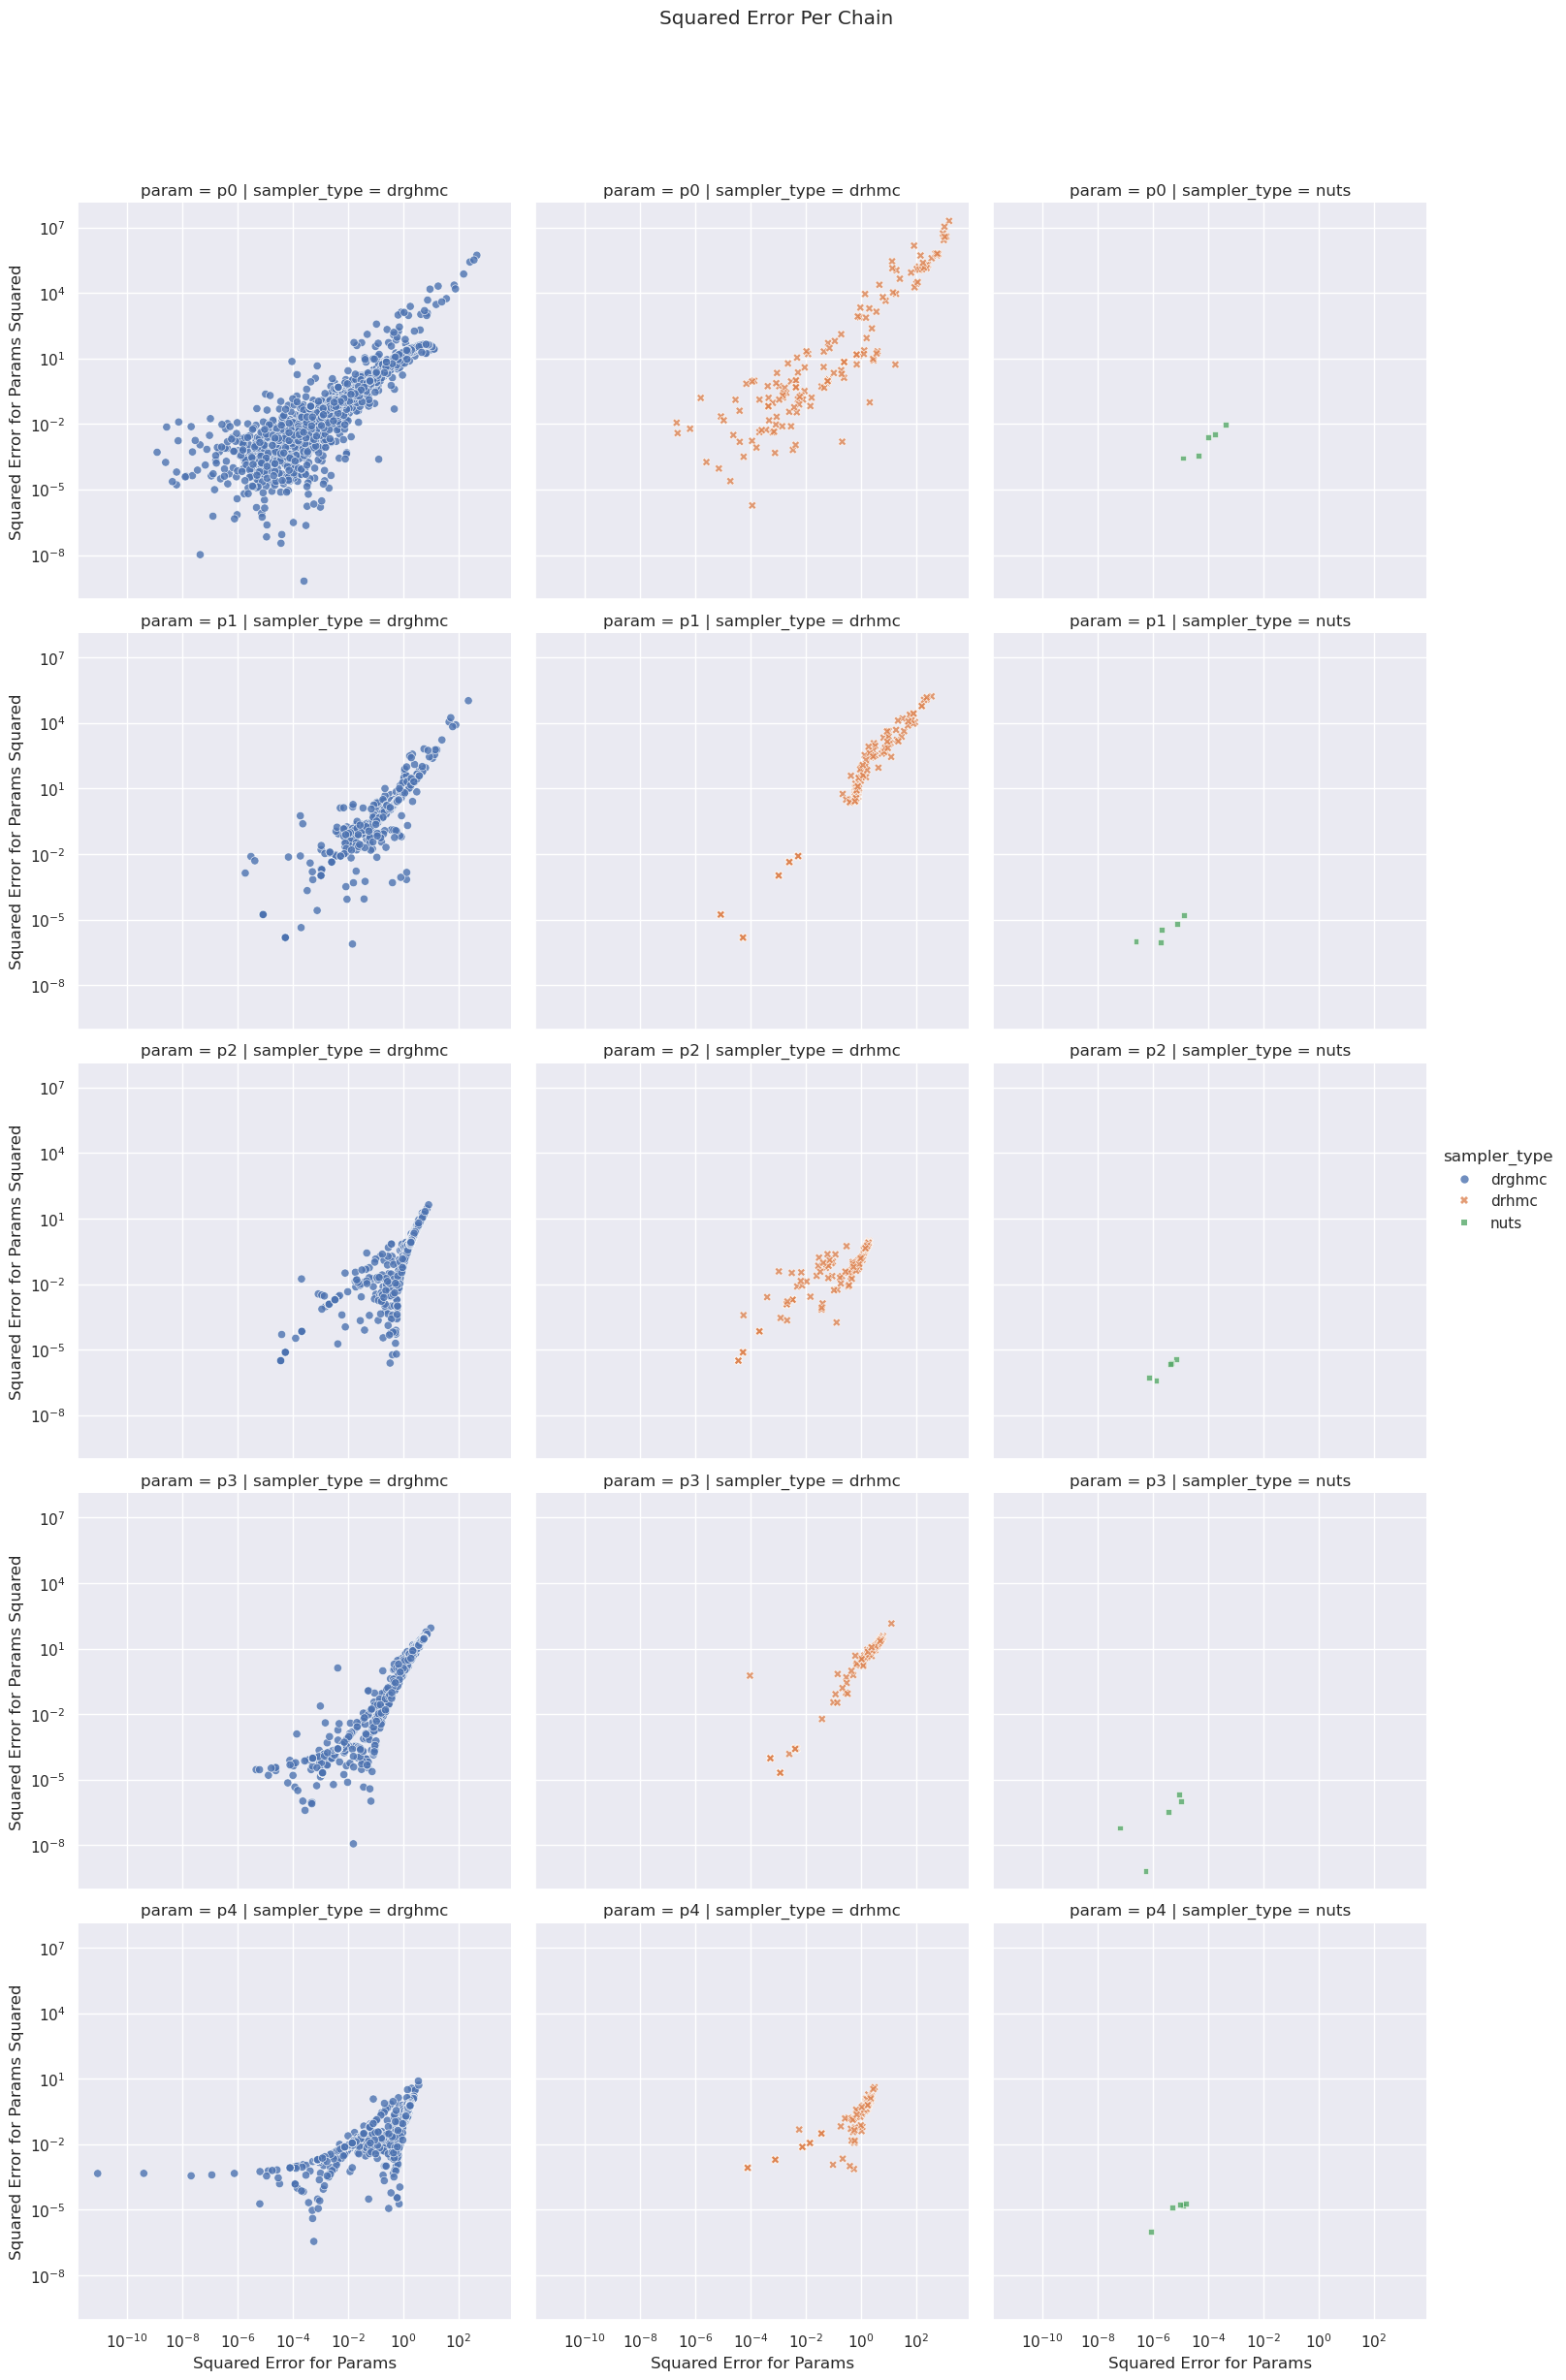

In [14]:
fig = sns.relplot(
    data=melted.to_pandas(),
    kind="scatter",
    x="se1",
    y="se2",
    hue="sampler_type",
    style="sampler_type",
    alpha=0.8,
    row="param",
    row_order=["p0", "p1", "p2", "p3", "p4"],
    col="sampler_type",
    col_order=["drghmc", "drhmc", "nuts"]
)
# rename x axis and y axis
fig.set(xlabel="Squared Error for Params", ylabel="Squared Error for Params Squared")
fig.set(xscale="log", yscale="log")
fig.fig.subplots_adjust(top = 0.9)
fig.fig.suptitle("Squared Error Per Chain")

In [15]:
melted_group = melted.group_by("param", "hparams").agg([
    pl.col("se1").std().alias("se1_std"),
    pl.col("se2").std().alias("se2_std"),
    pl.col("se1").mean().alias("se1_mean"),
    pl.col("se2").mean().alias("se2_mean"),
    pl.col("sampler_type").first().alias("sampler_type"),
    #pl.col("step_count_method").first().alias("step_count_method"),
    # pl.col("step_count_factor").first().alias("step_count_factor"),
    # pl.col("max_proposals").first().alias("max_proposals"),
    # pl.col("reduction_factor").first().alias("reduction_factor"),
    # pl.col("damping").first().alias("damping"),
])

# make new Polars column for the max of se1_std and se2_std 
melted_group = melted_group.with_columns(
    pl.when(pl.col("se1_std") > pl.col("se2_std")).then(pl.col("se1_std")).otherwise(pl.col("se2_std")).alias("max_std")
)
melted_group.describe()

statistic,param,hparams,se1_std,se2_std,se1_mean,se2_mean,sampler_type,max_std
str,str,str,f64,f64,f64,f64,str,f64
"""count""","""392045""","""392045""",392045.0,392045.0,392045.0,392045.0,"""392045""",392045.0
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,"""0""",0.0
"""mean""",null,null,0.175286,54.424221,1.14395,28.462817,null,54.522823
"""std""",null,null,2.074028,16715.735172,1.598714,8249.124081,null,16715.734853
"""min""","""p0""","""damping=0.01__…",1.2248e-7,6.5056e-7,1.4326e-7,5.5421e-7,"""drghmc""",7.9268e-7
"""25%""",null,null,0.022397,0.006095,0.972958,0.033728,null,0.023171
"""50%""",null,null,0.044785,0.018323,1.301615,0.099129,null,0.047613
"""75%""",null,null,0.159403,0.048964,1.506324,0.233661,null,0.187752
"""max""","""p499""","""sampler_type=n…",687.743635,8.8057e6,540.36292,3.9806e6,"""nuts""",8.8057e6


/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 0.98, 'Squared Error Per Hyperparameter Configuration')

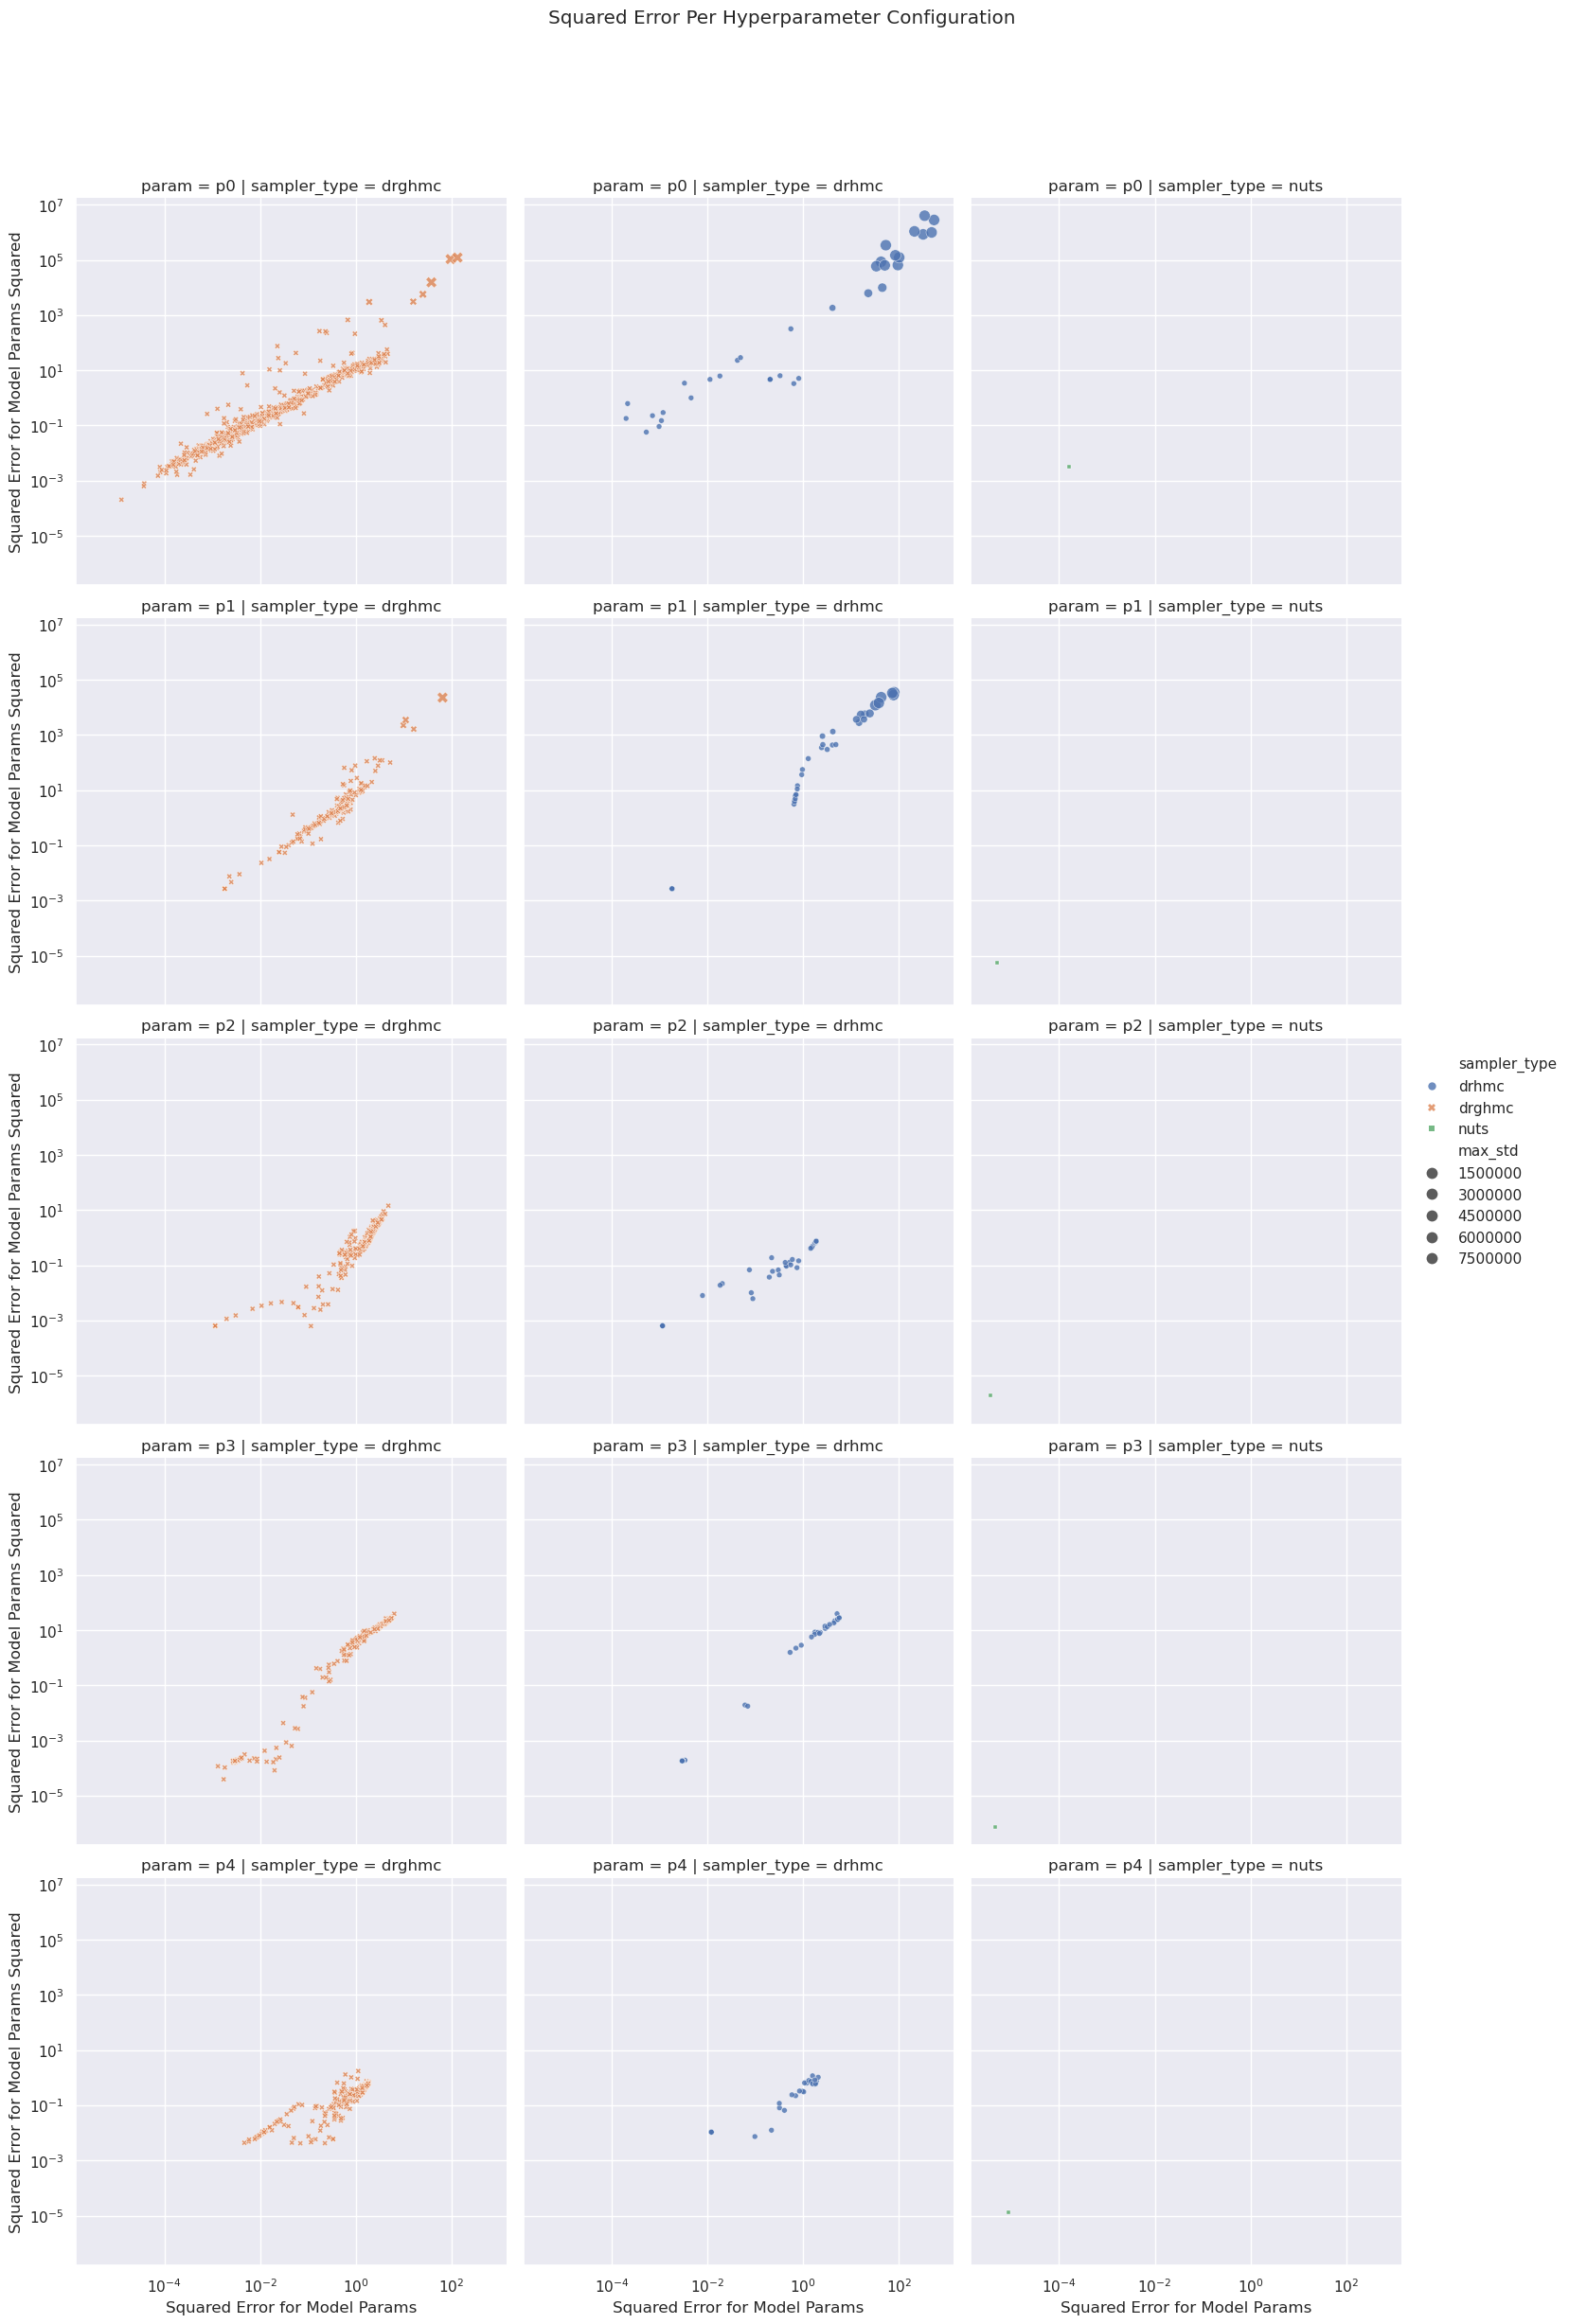

In [16]:
fig = sns.relplot(
    data=melted_group.to_pandas(),
    kind="scatter",
    x="se1_mean",
    y="se2_mean",
    hue="sampler_type",
    style="sampler_type",
    alpha=0.8,
    col="sampler_type",
    col_order=["drghmc", "drhmc", "nuts"],
    row="param",
    row_order=["p0", "p1", "p2", "p3", "p4"],
    size="max_std",
    size_norm=(1, 25000)
)
# rename x axis and y axis
fig.set(xlabel="Squared Error for Model Params", ylabel="Squared Error for Model Params Squared")
fig.set(xscale="log", yscale="log")
fig.fig.subplots_adjust(top = 0.9)
fig.fig.suptitle("Squared Error Per Hyperparameter Configuration")

# Max Relative Squared Error

In [ ]:
fig = sns.relplot(
    data=summary.to_pandas(),
    kind="scatter",
    x="max_rse1",
    y="max_rse2",
    hue="sampler_type",
    style="sampler_type",
    alpha=0.8,
    col="sampler_type",
    col_order=["drhmc", "nuts"]
)
# rename x axis and y axis
fig.set(xlabel="Max(Relative Squared Error for Params)", ylabel="Max(Relative Squared Error for Params Squared)")
fig.set(xscale="log", yscale="log")
fig.fig.subplots_adjust(top = 0.9)
fig.fig.suptitle("Max Relative Squared Error Per Chain")

In [ ]:
grouped = summary.group_by("hparams").agg([
    pl.col("max_rse1").std().alias("rse1_std"),
    pl.col("max_rse2").std().alias("rse2_std"),
    pl.col("max_rse1").mean().alias("rse1_mean"),
    pl.col("max_rse2").mean().alias("rse2_mean"),
    pl.col("sampler_type").first().alias("sampler_type"),
    #pl.col("step_count_method").first().alias("step_count_method"),
    pl.col("step_count_factor").first().alias("step_count_factor"),
    pl.col("max_proposals").first().alias("max_proposals"),
    pl.col("reduction_factor").first().alias("reduction_factor"),
    pl.col("damping").first().alias("damping"),
])

# make new Polars column for the max of se1_std and se2_std 
grouped = grouped.with_columns(
    pl.when(pl.col("rse1_std") > pl.col("rse2_std")).then(pl.col("rse1_std")).otherwise(pl.col("rse2_std")).alias("max_std")
)
grouped.describe()

In [ ]:
fig = sns.relplot(
    data=grouped.to_pandas(),
    kind="scatter",
    x="rse1_mean",
    y="rse2_mean",
    hue="sampler_type",
    style="sampler_type",
    alpha=0.8,
    col="sampler_type",
    col_order=["drhmc", "nuts"],
    size="max_std",
)
# rename x axis and y axis
fig.set(xlabel="Max(Relative Squared Error for Params)", ylabel="Max(Relative Squared Error for Params Squared)")
fig.set(xscale="log", yscale="log")
fig.fig.subplots_adjust(top = 0.9)
fig.fig.suptitle("Max Relative Squared Error Per Hyperparameter Setting")

# Relative Squared Error Per Parameter

In [ ]:
value_vars = [f"p{idx}_rse1" for idx in range(num_params)] + [f"p{idx}_rse2" for idx in range(num_params)]
id_vars = ["hparams", "sampler_type", "chain"]

melted = summary.melt(
    id_vars=id_vars,
    value_vars=value_vars, 
    variable_name="param_error", 
    value_name="squared error"
)

melted = melted.with_columns(
    pl.col("param_error")
    .str.split_exact(by="_", n=1)
    .struct.rename_fields(["param", "error_type"])
).unnest("param_error")

melted = melted.pivot(
    index=id_vars + ["param"],
    columns="error_type",
    values="squared error",
)

melted.head()    

In [ ]:
melted = melted.filter(pl.col("param").str.contains("p[0-1]"))
melted.head()

In [ ]:
fig = sns.relplot(
    data=melted.to_pandas(),
    kind="scatter",
    x="rse1",
    y="rse2",
    hue="sampler_type",
    style="sampler_type",
    alpha=0.8,
    row="param",
    row_order=["p0", "p1"],
    col="sampler_type",
    col_order=["drhmc", "nuts"]
)
# rename x axis and y axis
fig.set(xlabel="Relative Squared Error for Params", ylabel="Relative Squared Error for Params Squared")
fig.set(xscale="log", yscale="log")
fig.fig.subplots_adjust(top = 0.9)
fig.fig.suptitle("Relative Squared Error Per Chain")

In [ ]:
melted_group = melted.group_by("param", "hparams").agg([
    pl.col("rse1").std().alias("rse1_std"),
    pl.col("rse2").std().alias("rse2_std"),
    pl.col("rse1").mean().alias("rse1_mean"),
    pl.col("rse2").mean().alias("rse2_mean"),
    pl.col("sampler_type").first().alias("sampler_type"),
    #pl.col("step_count_method").first().alias("step_count_method"),
    # pl.col("step_count_factor").first().alias("step_count_factor"),
    # pl.col("max_proposals").first().alias("max_proposals"),
    # pl.col("reduction_factor").first().alias("reduction_factor"),
    # pl.col("damping").first().alias("damping"),
])

# make new Polars column for the max of se1_std and se2_std 
melted_group = melted_group.with_columns(
    pl.when(pl.col("rse1_std") > pl.col("rse2_std")).then(pl.col("rse1_std")).otherwise(pl.col("rse2_std")).alias("max_std")
)
melted_group.describe()

In [ ]:
fig = sns.relplot(
    data=melted_group.to_pandas(),
    kind="scatter",
    x="rse1_mean",
    y="rse2_mean",
    hue="sampler_type",
    style="sampler_type",
    alpha=0.8,
    col="sampler_type",
    col_order=["drhmc", "nuts"],
    row="param",
    row_order=["p0", "p1"],
    size="max_std",
)
# rename x axis and y axis
fig.set(xlabel="Relative Squared Error for Model Params", ylabel="Relative Squared Error for Model Params Squared")
fig.set(xscale="log", yscale="log")
fig.fig.subplots_adjust(top = 0.9)
fig.fig.suptitle("Relative Squared Error Per Hyperparameter Configuration")